<h1>Capstone</h1>

Travellers often face an uphill task when deciding upon which spots to visit.<br>
In this project I address the following problems: 
    - With limited time travellers do not want to visit spots which are similar 
    - They also find it difficult to go through hundreds of peer reviews to judge a spot
    
    The first problem is addressed through clustering of prominent areas in a city 
    The second problem is addressed through WordCloud generation of historic reviews
    
     Datasets used :
     - Wikipedia: Neighbourhood data with coordinates
     - Geocoder: Other relevant coordinates
     - Foursquare: Places API (Explore and Tips endpoints)
     
     Further scope:
     - Food chain networks can be clustered to understand customer segments in the city
     - Entrepreneurs can leverage such visualizations for market entry decisions
     - Foursquare endpoint limits cause premature termination, enough datapoints can lead to interesting insights
     - Analy

<h3>Installing relevant libraries</h3>

In [1]:
! pip install geocoder
! pip install folium

     |████████████████████████████████| 102kB 7.8MB/s ta 0:00:011
     |████████████████████████████████| 102kB 7.7MB/s ta 0:00:011


In [63]:
!pip install wordcloud

     |████████████████████████████████| 368kB 10.7MB/s eta 0:00:01


<h3>Importing relevant libraries

In [2]:
#import relevant libraries
import pandas as pd # data analysis
import geocoder # convert address to lat and long
from geopy.geocoders import Nominatim 
import folium # map rendering
import requests # handle url requests
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors

In [3]:
import pandas as pd

<h3>Mumbai City, India is chosen for analysis</h3><br>
- Neighbourhood data from Wikipedia is scrapped

In [4]:
link = 'https://en.wikipedia.org/wiki/List_of_neighbourhoods_in_Mumbai'
tables = pd.read_html(link)
df = pd.DataFrame(tables[0])
df.drop(['Location'], axis = 1, inplace = True)

In [5]:
df.head()

,Area,Latitude,Longitude
0,Amboli,19.129300,72.843400
1,"Chakala, Andheri",19.111388,72.860833
2,D.N. Nagar,19.124085,72.831373
3,Four Bungalows,19.124714,72.827210
4,Lokhandwala,19.130815,72.829270


In [6]:
address = 'Mumbai, India'
geolocator = Nominatim(user_agent="explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Mumbai are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Mumbai are 19.0759899, 72.8773928.


<h3>Neighbourhood Map is as shown below

In [7]:
# create map of Mumbai
map_mumbai = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, area in zip(df['Latitude'], df['Longitude'], df['Area']):
    label = '{}'.format(area)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_mumbai)
    
map_mumbai

In [8]:
CLIENT_ID = '315JI21RCJPMNU5QHYDBU1SL3VRE5KFVYGKHE2YMTZQFPVLI' # your Foursquare ID
CLIENT_SECRET = 'YXJFLJVB5DER5KC2TRX1BIOWB1GMKBTOXMJ1LRSUISVNSHXZ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [9]:
def getNearbyVenues(names, latitudes, longitudes, radius=5000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'],   
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Area', 
                  'Latitude', 
                  'Longitude', 
                  'Venue',  
                  'Venue Category']
    
    return(nearby_venues)

In [10]:
LIMIT = 100
mumbai_venues = getNearbyVenues(names=df['Area'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude'])

<h3>Nearby venues are extracted using Foursquare Explore endpoint

In [11]:
mumbai_venues.head()

,Area,Latitude,Longitude,Venue,Venue Category
0,Amboli,19.1293,72.8434,Merwans Cake shop,Bakery
1,Amboli,19.1293,72.8434,Hard Rock Cafe Andheri,American Restaurant
2,Amboli,19.1293,72.8434,Jaffer Bhai's Delhi Darbar,Mughlai Restaurant
3,Amboli,19.1293,72.8434,Shawarma Factory,Falafel Restaurant
4,Amboli,19.1293,72.8434,Joey's Pizza,Pizza Place


In [12]:
len(mumbai_venues['Venue Category'].unique())

179

<h3>The data is explored to get a sense of the entire city<br>
    <h5>- Such data can also be useful for businesses looking to expand in new segments and geographies
       

In [13]:
mumbai_venues.groupby('Venue Category').count().sort_values(['Area'], ascending = False, axis = 0).head(10)

,Area,Latitude,Longitude,Venue
Venue Category,,,,
Indian Restaurant,1067,1067,1067,1067
Ice Cream Shop,404,404,404,404
Café,364,364,364,364
Coffee Shop,310,310,310,310
Hotel,301,301,301,301
Restaurant,271,271,271,271
Dessert Shop,271,271,271,271
Fast Food Restaurant,248,248,248,248
Chinese Restaurant,221,221,221,221


In [14]:
mumbai_venues=mumbai_venues[mumbai_venues['Venue Category']!='Indian Restaurant']

In [15]:
# one hot encoding
mumbai_onehot = pd.get_dummies(mumbai_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighbourhood column back to dataframe
mumbai_onehot['Area'] = mumbai_venues['Area'] 

# move neighbourhood column to the first column
fixed_columns = [mumbai_onehot.columns[-1]] + list(mumbai_onehot.columns[:-1])
mumbai_onehot = mumbai_onehot[fixed_columns]

mumbai_grouped = mumbai_onehot.groupby('Area').mean()


In [16]:
mumbai_grouped.reset_index(inplace=True)

In [17]:
mumbai_grouped.head(1)

,Area,Afghan Restaurant,Airport Service,American Restaurant,Arcade,Art Gallery,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,...,Theater,Theme Park,Toy / Game Store,Track,Train Station,Vegetarian / Vegan Restaurant,Water Park,Wine Bar,Wine Shop,Women's Store
0,Aarey Milk Colony,0.0,0.0,0.0,0.0,0.0,0.036145,0.0,0.0,0.012048,...,0.0,0.0,0.0,0.0,0.0,0.024096,0.0,0.0,0.0,0.0


<h3>K-Means clustering for clustering Neghbourhoods based on Venue Categories

In [18]:
kclusters = 9

mumbai_grouped_clustering = mumbai_grouped.drop('Area', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(mumbai_grouped_clustering) 

# add clustering labels
mumbai_grouped.insert(0, 'Cluster Labels', kmeans.labels_)

mumbai_merged = df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
mumbai_merged = mumbai_merged.join(mumbai_grouped.set_index('Area'), on='Area')

mumbai_merged.head() # check the last columns!

,Area,Latitude,Longitude,Cluster Labels,Afghan Restaurant,Airport Service,American Restaurant,Arcade,Art Gallery,Asian Restaurant,...,Theater,Theme Park,Toy / Game Store,Track,Train Station,Vegetarian / Vegan Restaurant,Water Park,Wine Bar,Wine Shop,Women's Store
0,Amboli,19.129300,72.843400,5.0,0.0,0.000000,0.022727,0.0,0.0,0.011364,...,0.011364,0.0,0.000000,0.011364,0.0,0.0,0.0,0.0,0.0,0.0
1,"Chakala, Andheri",19.111388,72.860833,5.0,0.0,0.011236,0.022472,0.0,0.0,0.022472,...,0.011236,0.0,0.011236,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,D.N. Nagar,19.124085,72.831373,5.0,0.0,0.000000,0.022727,0.0,0.0,0.000000,...,0.011364,0.0,0.000000,0.011364,0.0,0.0,0.0,0.0,0.0,0.0
3,Four Bungalows,19.124714,72.827210,5.0,0.0,0.000000,0.022472,0.0,0.0,0.000000,...,0.011236,0.0,0.000000,0.011236,0.0,0.0,0.0,0.0,0.0,0.0
4,Lokhandwala,19.130815,72.829270,5.0,0.0,0.000000,0.022727,0.0,0.0,0.000000,...,0.011364,0.0,0.000000,0.011364,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
mumbai_merged.dropna(inplace=True)

In [20]:
mumbai_merged['Cluster Labels'] = mumbai_merged['Cluster Labels'].astype(int)

<h3>The resulting 9 clusters are visualized as shown below</h3>

In [21]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(mumbai_merged['Latitude'], mumbai_merged['Longitude'], mumbai_merged['Area'], mumbai_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [22]:
mumbai_plot=mumbai_merged.groupby('Cluster Labels').mean()

In [23]:
mumbai_plot.drop(['Latitude'],axis=1,inplace=True)
mumbai_plot.drop(['Longitude'],axis=1,inplace=True)

In [24]:
mumbai_plot.reset_index(inplace=True)

<h3>Each cluster is analysed for providing descriptions to categories<br>
    <h6>- Such a dataset can also be used as a recommender system if number of clusters are increased

In [25]:
mumbai_plot

,Cluster Labels,Afghan Restaurant,Airport Service,American Restaurant,Arcade,Art Gallery,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,...,Theater,Theme Park,Toy / Game Store,Track,Train Station,Vegetarian / Vegan Restaurant,Water Park,Wine Bar,Wine Shop,Women's Store
0,0,0.000000,0.000000,0.001221,0.010117,0.000000,0.002661,0.002661,0.004884,0.000000,...,0.004884,0.000000,0.000000,0.000000,0.000000,0.009033,0.000000,0.000000,0.000000,0.005356
1,1,0.000000,0.000000,0.000000,0.000000,0.000631,0.011376,0.009475,0.000000,0.000639,...,0.002511,0.000000,0.011986,0.000000,0.000000,0.014680,0.000000,0.000000,0.000000,0.004747
2,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000
3,3,0.000000,0.000000,0.003647,0.003312,0.000000,0.006502,0.001579,0.000000,0.009736,...,0.003878,0.009371,0.000000,0.000000,0.014296,0.016140,0.007470,0.001579,0.000000,0.001959
4,4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.031746,0.000000,0.000000,0.000000,0.000000,0.031746,0.000000,0.000000,0.000000
5,5,0.000000,0.002831,0.022335,0.001832,0.000000,0.005672,0.000000,0.007440,0.010222,...,0.010281,0.000000,0.000936,0.006505,0.000000,0.000887,0.000000,0.000000,0.000000,0.000000
6,6,0.008109,0.005859,0.009444,0.002961,0.000000,0.018387,0.001454,0.000000,0.007300,...,0.001429,0.008109,0.007365,0.000672,0.003768,0.023578,0.000000,0.000735,0.000000,0.000000
7,7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,8,0.000000,0.000000,0.000764,0.000000,0.011757,0.011757,0.000000,0.000000,0.000000,...,0.013064,0.000000,0.000646,0.000000,0.000764,0.007793,0.000000,0.000000,0.000764,0.000000


In [26]:
mumbai_plot=mumbai_plot.drop(['Cluster Labels'],axis=1).T.reset_index()

In [27]:
mumbai_plot.head(2)

,index,0,1,2,3,4,5,6,7,8
0,Afghan Restaurant,0.0,0.0,0.0,0.0,0.0,0.000000,0.008109,0.0,0.0
1,Airport Service,0.0,0.0,0.0,0.0,0.0,0.002831,0.005859,0.0,0.0


In [28]:
import seaborn as sns
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(20,4))
sns.barplot(x='index',y=7,data=mumbai_plot[mumbai_plot[7]>0.03], ax=ax)

<h3>Prominent clusters can be analyzed graphically to give description to categories </h3> 

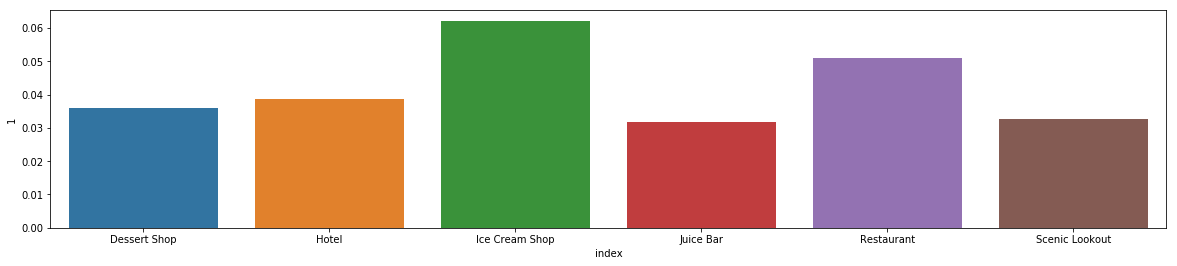

In [29]:
fig, ax = plt.subplots(figsize=(20,4))
sns.barplot(x='index',y=1,data=mumbai_plot[mumbai_plot[1]>0.03], ax=ax)

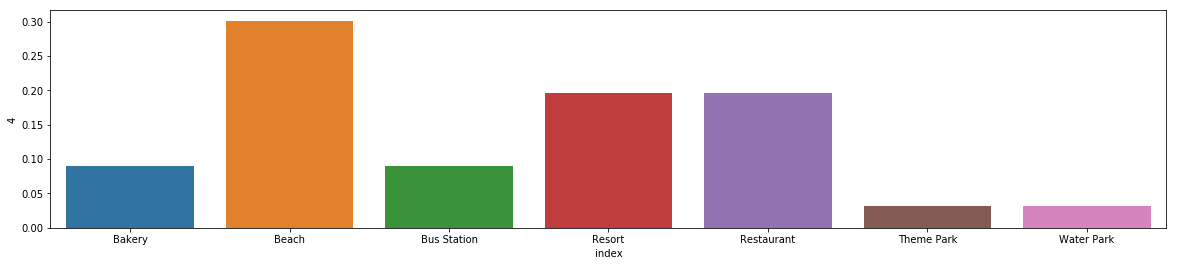

In [30]:
fig, ax = plt.subplots(figsize=(20,4))
sns.barplot(x='index',y=4,data=mumbai_plot[mumbai_plot[4]>0.03], ax=ax)

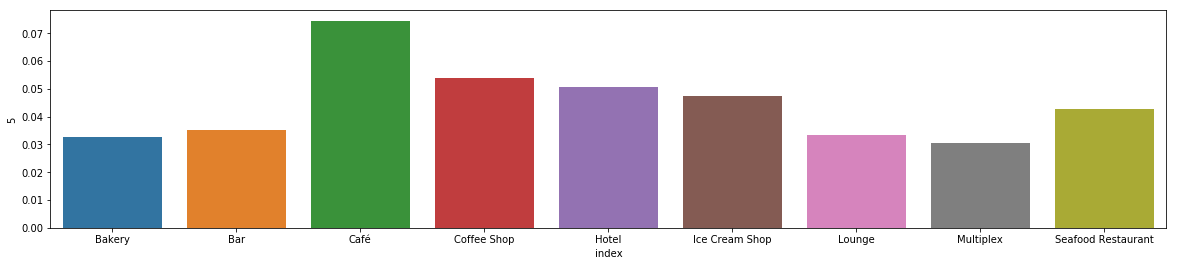

In [31]:
fig, ax = plt.subplots(figsize=(20,4))
sns.barplot(x='index',y=5,data=mumbai_plot[mumbai_plot[5]>0.03], ax=ax)

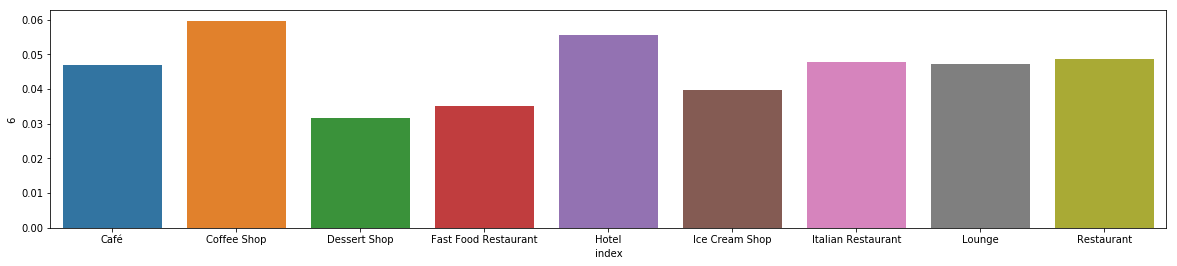

In [79]:
fig, ax = plt.subplots(figsize=(20,4))
sns.barplot(x='index',y=6,data=mumbai_plot[mumbai_plot[6]>0.03], ax=ax)

In [32]:
mumbai_venues.head()

,Area,Latitude,Longitude,Venue,Venue Category
0,Amboli,19.1293,72.8434,Merwans Cake shop,Bakery
1,Amboli,19.1293,72.8434,Hard Rock Cafe Andheri,American Restaurant
2,Amboli,19.1293,72.8434,Jaffer Bhai's Delhi Darbar,Mughlai Restaurant
3,Amboli,19.1293,72.8434,Shawarma Factory,Falafel Restaurant
4,Amboli,19.1293,72.8434,Joey's Pizza,Pizza Place


<h3>Prominent Venues are identified for understanding their network correlation with identified clusters

In [33]:
mumbai_venues.groupby('Venue').count().sort_values(['Area'], ascending = False, axis = 0).head(15)

,Area,Latitude,Longitude,Venue Category
Venue,,,,
Starbucks,177,177,177,177
Theobroma,80,80,80,80
Cafe Coffee Day,53,53,53,53
Doolally Taproom,41,41,41,41
Domino's Pizza,39,39,39,39
Mad Over Donuts,39,39,39,39
Mainland China,36,36,36,36
Subway,36,36,36,36
Trident,35,35,35,35


In [34]:
mumbai_sb=mumbai_venues[mumbai_venues['Venue']=='Starbucks']

In [35]:
mumbai_sb=mumbai_sb.groupby('Area').mean().reset_index()

<h3> Starbucks seems to exist in all clusters </h3>

In [36]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
#x = np.arange(kclusters)
#ys = [i + x + (i*x)**2 for i in range(kclusters)]
#colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
#rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi in zip(mumbai_sb['Latitude'], mumbai_sb['Longitude'], mumbai_sb['Area']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='green',
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<h3>Cafe Coffee Day, Domino's Pizza and Subway seem to exist in only certain clusters

In [37]:
mumbai_ccd=mumbai_venues[mumbai_venues['Venue']=='Cafe Coffee Day']
mumbai_ccd=mumbai_ccd.groupby('Area').mean().reset_index()
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
#x = np.arange(kclusters)
#ys = [i + x + (i*x)**2 for i in range(kclusters)]
#colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
#rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi in zip(mumbai_ccd['Latitude'], mumbai_ccd['Longitude'], mumbai_ccd['Area']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [38]:
mumbai_dp=mumbai_venues[mumbai_venues['Venue']=='Domino\'s Pizza']
mumbai_dp=mumbai_dp.groupby('Area').mean().reset_index()
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
#x = np.arange(kclusters)
#ys = [i + x + (i*x)**2 for i in range(kclusters)]
#colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
#rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi in zip(mumbai_dp['Latitude'], mumbai_dp['Longitude'], mumbai_dp['Area']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [39]:
mumbai_sw=mumbai_venues[mumbai_venues['Venue']=='Subway']
mumbai_sw=mumbai_sw.groupby('Area').mean().reset_index()
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
#x = np.arange(kclusters)
#ys = [i + x + (i*x)**2 for i in range(kclusters)]
#colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
#rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi in zip(mumbai_sw['Latitude'], mumbai_sw['Longitude'], mumbai_sw['Area']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [40]:
mumbai_venues.head()

,Area,Latitude,Longitude,Venue,Venue Category
0,Amboli,19.1293,72.8434,Merwans Cake shop,Bakery
1,Amboli,19.1293,72.8434,Hard Rock Cafe Andheri,American Restaurant
2,Amboli,19.1293,72.8434,Jaffer Bhai's Delhi Darbar,Mughlai Restaurant
3,Amboli,19.1293,72.8434,Shawarma Factory,Falafel Restaurant
4,Amboli,19.1293,72.8434,Joey's Pizza,Pizza Place


<h3>Neighbourhoods are picked for WordCloud generation of User Reviews<br>
 <h6>   - Churchgate and Hiranandani Gardens are picked

In [41]:
mumbai_venues['Area'].value_counts()

Bangur Nagar           94
Sunder Nagar           93
Thakur village         92
Dindoshi               92
Khar Danda             92
Poisar                 92
Chor Bazaar            91
Dava Bazaar            91
Marine Drive           91
Pali Naka              91
Ballard Estate         91
Churchgate             91
Vile Parle             91
Kalina                 91
Juhu                   91
Marine Lines           91
Fanas Wadi             91
Seven Bungalows        91
Mahavir Nagar          91
Bhuleshwar             91
Dhobitalao             90
Chira Bazaar           90
Charkop                90
Malabar Hill           90
Pali Hill              90
Versova                90
Walkeshwar             90
Cavel                  90
Chakala, Andheri       89
Irla                   89
                       ..
Chembur                84
Hiranandani Gardens    84
Chandivali             84
Mahim                  84
Aarey Milk Colony      83
Bandstand Promenade    83
Amrut Nagar            83
Deonar      

In [42]:
mumbai_venues_hg=mumbai_venues[mumbai_venues['Area']=='Hiranandani Gardens']

In [51]:
CLIENT_ID = 'IZRRM13P2OVZFUFKBKZOCZFHZGBQ0GINTZN03T3FD3XYDNQG'
CLIENT_SECRET = 'TY2DS234M211OLQBXBAHFEOLV4U235DLJ0LTESUCQ4ALSBOV'

def getNearbyVenues(names, latitudes, longitudes, radius=5000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'],  
            v['venue']['id'],
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Area', 
                  'Latitude', 
                  'Longitude', 
                  'Venue',
                  'Venue ID',
                  'Venue Category']
    
    return(nearby_venues)

In [52]:
LIMIT = 100
mumbai_venues = getNearbyVenues(names=df['Area'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude'])

In [53]:
mumbai_venues_hg = mumbai_venues[mumbai_venues['Area']=='Hiranandani Gardens']

<h3>Venue IDs are extracted from Foursquare Venues endpoint for use with Tips endpoint

In [54]:
mumbai_venues_hg.head()

,Area,Latitude,Longitude,Venue,Venue ID,Venue Category
3875,Hiranandani Gardens,19.118986,72.911767,Starbucks,50f63f31e4b050d06e1cb448,Coffee Shop
3876,Hiranandani Gardens,19.118986,72.911767,Theobroma,51661e48e4b080e1e81485a5,Bakery
3877,Hiranandani Gardens,19.118986,72.911767,Mia Cucina,4fe7292be4b0e1967f08a489,Italian Restaurant
3878,Hiranandani Gardens,19.118986,72.911767,Mirchi And Mime,55463c55498ef91e86b51620,North Indian Restaurant
3879,Hiranandani Gardens,19.118986,72.911767,Le Pain Quotidien,52a3180011d219b98b30e785,Bakery


<h3> Tips list data from Foursquare is used for WordCloud based visualization of User Reviews</h3>

In [55]:
tips_list = []
for VENUE_ID in mumbai_venues_hg['Venue ID']:
    url = 'https://api.foursquare.com/v2/venues/{}/tips?&client_id={}&client_secret={}&v={}'.format(
            VENUE_ID,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)

    results = requests.get(url).json()["response"]['tips']['items'][0]['text']
    
    tips_list.append([(
            VENUE_ID, 
            results)])
   
    

KeyError: 'tips'

In [56]:
tips_list

[[('50f63f31e4b050d06e1cb448',
   "Best thing about Starbucks, India is let's say if your Latte is not up to the mark even if you finish half of your mug, they make it completely  new Latte for you and also with an extra shot. :)")],
 [('51661e48e4b080e1e81485a5',
   'The butty burger with chicken or bacon is the bomb and also Harissa Chicken. The Desserts are anyways yummy at Theobrama.')],
 [('4fe7292be4b0e1967f08a489',
   "ASK for Caprese salad. Not on the menu but these guys nail it. The ambience is an irresistible compound of dreamy and lively! Got a blind date? You'd have to try real hard to go wrong with this one.")],
 [('55463c55498ef91e86b51620',
   'Apart from that it is an amazing looking restaurant, the food is awesome! And the concept is supercool! All staff is happy and very friendly and happy. Really worthwhile!')],
 [('52a3180011d219b98b30e785',
   'Everything that u order comes with a bread as a main ingredient. Good to avoid if u hate to eat breads. Btw garlic bread i

In [57]:
mumbai_hg_tips = pd.DataFrame(text for item in tips_list for text in item )
mumbai_hg_tips.columns = ['Venue ID','Tip']

In [58]:
mumbai_hg_tips.head()

,Venue ID,Tip
0,50f63f31e4b050d06e1cb448,"Best thing about Starbucks, India is let's say..."
1,51661e48e4b080e1e81485a5,The butty burger with chicken or bacon is the ...
2,4fe7292be4b0e1967f08a489,ASK for Caprese salad. Not on the menu but the...
3,55463c55498ef91e86b51620,Apart from that it is an amazing looking resta...
4,52a3180011d219b98b30e785,Everything that u order comes with a bread as ...


In [59]:
mumbai_hg=mumbai_venues_hg.merge(mumbai_hg_tips, on='Venue ID', how='left')

In [60]:
mumbai_hg.dropna(inplace=True)

In [61]:
mumbai_hg.head()

,Area,Latitude,Longitude,Venue,Venue ID,Venue Category,Tip
0,Hiranandani Gardens,19.118986,72.911767,Starbucks,50f63f31e4b050d06e1cb448,Coffee Shop,"Best thing about Starbucks, India is let's say..."
1,Hiranandani Gardens,19.118986,72.911767,Theobroma,51661e48e4b080e1e81485a5,Bakery,The butty burger with chicken or bacon is the ...
2,Hiranandani Gardens,19.118986,72.911767,Mia Cucina,4fe7292be4b0e1967f08a489,Italian Restaurant,ASK for Caprese salad. Not on the menu but the...
3,Hiranandani Gardens,19.118986,72.911767,Mirchi And Mime,55463c55498ef91e86b51620,North Indian Restaurant,Apart from that it is an amazing looking resta...
4,Hiranandani Gardens,19.118986,72.911767,Le Pain Quotidien,52a3180011d219b98b30e785,Bakery,Everything that u order comes with a bread as ...


In [76]:
# instantiate a word cloud object
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
hg_wc = WordCloud(
    background_color='white',
    max_words=2000,
    stopwords=stopwords
)

# generate the word cloud
stopwords.add('best')
stopwords.add('good')
hg_wc.generate(mumbai_hg['Tip'].to_string())

<h3>Hiranandani Gardens seems to be popular for Chicken and Ambience

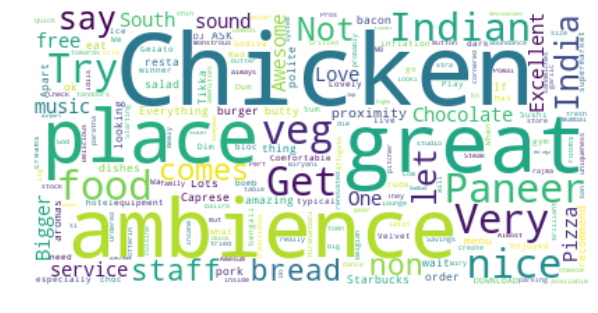

In [78]:
fig = plt.figure()
fig.set_figwidth(10) # set width
fig.set_figheight(10) # set height

# display the cloud
plt.imshow(hg_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

In [80]:
mumbai_venues_cg = mumbai_venues[mumbai_venues['Area']=='Churchgate']

In [81]:
mumbai_venues_cg.head()

,Area,Latitude,Longitude,Venue,Venue ID,Venue Category
5229,Churchgate,18.93,72.82,Nariman Point,4c14f8be82a3c9b6b6fefdf8,Scenic Lookout
5230,Churchgate,18.93,72.82,The Sassy Spoon,510be019e4b04c8c9a348a1a,Diner
5231,Churchgate,18.93,72.82,National Centre for the Performing Arts (NCPA),4e03166fb3ad7a4de179a603,Performing Arts Venue
5232,Churchgate,18.93,72.82,Trident,4c1efc7963750f474693ba67,Hotel
5233,Churchgate,18.93,72.82,Tata Theatre,4eb27d72b80348350a113945,Theater


In [82]:
CLIENT_ID = 'TI4FDYP0WCCCGFD0H1SE2ONC4YIUQ4FIL0TPQ4XG3CDOEFED'
CLIENT_SECRET = '5SHRILJDP1AEPTCEV1PIVEYITTWKNR4CQ3Q4IL4MYFN15RMJ'
tips_list_cg = []
for VENUE_ID in mumbai_venues_cg['Venue ID']:
    url = 'https://api.foursquare.com/v2/venues/{}/tips?&client_id={}&client_secret={}&v={}'.format(
            VENUE_ID,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)

    results = requests.get(url).json()["response"]['tips']['items'][0]['text']
    
    tips_list_cg.append([(
            VENUE_ID, 
            results)])
   
    

KeyError: 'tips'

In [84]:
mumbai_cg_tips = pd.DataFrame(text for item in tips_list_cg for text in item )
mumbai_cg_tips.columns = ['Venue ID','Tip']

In [85]:
mumbai_cg_tips.head()

,Venue ID,Tip
0,4c14f8be82a3c9b6b6fefdf8,Best place to hangout ! With the best appartme...
1,510be019e4b04c8c9a348a1a,Brilliant food. Do not forget to have spaghett...
2,4e03166fb3ad7a4de179a603,The NCPA has a year round calendar of best-sel...
3,4c1efc7963750f474693ba67,It has a beautiful full scape view of the sea....
4,4eb27d72b80348350a113945,B sure to bump into the simone Tata's n yash c...


In [86]:
mumbai_cg=mumbai_venues_cg.merge(mumbai_cg_tips, on='Venue ID', how='left')

In [94]:
mumbai_cg.dropna(inplace=True)

In [106]:
# instantiate a word cloud object
stopwords.add('best')
stopwords.add('good')
stopwords.add('This')
stopwords.add('place')
stopwords.add('amazing')
stopwords.add('You')
cg_wc = WordCloud(
    background_color='white',
    max_words=2000,
    stopwords=stopwords
)

# generate the word cloud


cg_wc.generate(mumbai_cg['Tip'].to_string())

<h3>Churchgate seems to be popular for Hangouts and Scenic Views

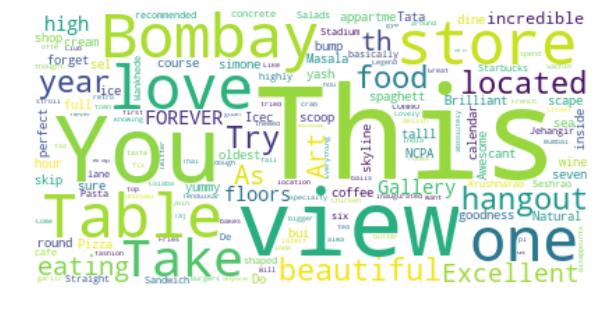

In [107]:
fig = plt.figure()
fig.set_figwidth(10) # set width
fig.set_figheight(10) # set height

# display the cloud
plt.imshow(cg_wc, interpolation='bilinear')
plt.axis('off')
plt.show()